# Diagnostics of simulation results

Text(0.5,1,'time-frequency spectrogram')

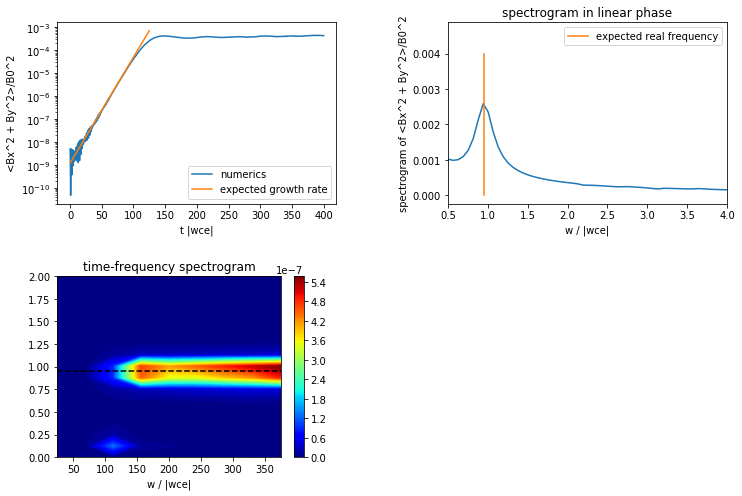

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from Utils.dispersionSolver import solveDispersionHybrid
from Utils.matrixAssembly import matrixAssembly
from Utils.createBasis import createBasis
from scipy import signal
from matplotlib.colors import LogNorm


# ... import simulation data
data = np.loadtxt('Results/01_WavenumberScan/simulation_data_T=400_k=2.0.txt')
# ...


# ... get simulation parameters
pa = data[0]

eps0  = pa[0]
mu0   = pa[1]
c     = pa[2]
qe    = pa[3]
me    = pa[4]
B0z   = pa[5]
wce   = pa[6]
wpe   = pa[7]
nuh   = pa[8]
nh    = pa[9]
wpar  = pa[10]
wperp = pa[11]
k     = pa[12]
ini   = np.int(pa[13])
amp   = pa[14]
eps   = pa[15]
Lz    = pa[16]
Nz    = np.int(pa[17])
T     = pa[18]
dt    = pa[19]
p     = np.int(pa[20])
Lv    = pa[21]
Nv    = np.int(pa[22])
Np    = np.int(pa[23])
# ...



# ... additional parameters 
Nb = Nz
s = 6
ordering = 0
# ...



# ... discretization parameters
dz = Lz/Nz
zj = np.linspace(0,Lz,Nz+1)

Nt = np.int(T/dt)
tn = np.linspace(0,T,Nt+1)
# ...




# ... get simulation data
if ordering == 0:
    
    uj = data[1:,0:s*Nb]
    yhj = data[1:,s*Nb:8*Nb]
    
    ejx = uj[:,0::6]
    ejy = uj[:,1::6]
    bjx = uj[:,2::6]
    bjy = uj[:,3::6]
    ycjx = uj[:,4::6]
    ycjy = uj[:,5::6]
    yhjx = yhj[:,0::2]
    yhjy = yhj[:,1::2]
    
elif ordering == 1:
    
    ej = data[1:,0:2*Nb]
    bj = data[1:,2*Nb:4*Nb]
    ycj = data[1:,4*Nb:6*Nb]
    yhj = data[1:,6*Nb:8*Nb]
    
    ejx = ej[:,0::2]
    ejy = ej[:,1::2]
    bjx = bj[:,0::2]
    bjy = bj[:,1::2]
    ycjx = ycj[:,0::2]
    ycjy = ycj[:,1::2]
    yhjx = yhj[:,0::2]
    yhjy = yhj[:,1::2]   
# ...






# ... create B-spline basis and compute mass matrix
basis,N,quad_points,weights = createBasis(Lz,Nz,p)
M = matrixAssembly(basis,p,Nz,weights,quad_points)[0]
# ...




# ... solve the dispersion relation for a fixed k to get ocillation frequency and growth rate 
omega = solveDispersionHybrid(k,+1,c,wce,wpe,wpar,wperp,nuh,0.5 + 0j,1e-6,100)[0]
omega_r = np.real(omega)
gamma = np.imag(omega)
# ...





# ... compute averaged quadratic magnetic field
mean_Bx2 = np.zeros(Nt+1)
mean_B2 = np.zeros(Nt+1)

for j in range(0,Nt+1):
    mean_Bx2[j] = 1/Lz*np.dot(bjx[j],np.dot(M,bjx[j]))
    mean_B2[j] = 1/Lz*(np.dot(bjx[j],np.dot(M,bjx[j])) + np.dot(bjy[j],np.dot(M,bjy[j])))
# ...

                       
                       
# ... compute fft for frequency analysis in linear phase 
Ntend = 2000
spec = np.fft.fft(mean_Bx2[0:Ntend+1])
spec = np.fft.fftshift(spec)
w = np.linspace(0,Ntend,Ntend+1) - Ntend/2
w = 2*np.pi*w/(Ntend*dt)
# ...



# ... compute time-frequency spectrum
f, t, Sxx = signal.spectrogram(mean_Bx2[0:],1/dt,nperseg=1000,noverlap=None,nfft=None)
om = 2*np.pi*f
lvls = np.logspace(-15,-6,200)
Time,Omega = np.meshgrid(t,om)
# ...

                       
# ... plot results
f1 = plt.figure()
f1.set_figheight(8)
f1.set_figwidth(12)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)

plt.subplot(221)
plt.semilogy(tn,mean_B2,label = 'numerics')
t2 = np.linspace(0,125,100)
plt.semilogy(t2,1.2e-9*np.exp(t2*gamma*2),label = 'expected growth rate')
plt.xlabel('t |wce|')
plt.ylabel('<Bx^2 + By^2>/B0^2')
plt.legend()

plt.subplot(222)
plt.plot(w,np.abs(spec))
plt.xlim((0.5,4))
plt.xlabel('w / |wce|')
plt.ylabel('spectrogram of <Bx^2 + By^2>/B0^2')
plt.plot(np.ones(20)*2*omega_r,np.linspace(0,4e-3,20),label = 'expected real frequency')
plt.legend()
plt.title('spectrogram in linear phase')


plt.subplot(223)
plt.contourf(Time,Omega,Sxx,100,cmap = 'jet')
#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')

plt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')
plt.xlabel('t |wce|')
plt.xlabel('w / |wce|')
plt.ylim((0,2))
plt.colorbar()
plt.title('time-frequency spectrogram')

# ...

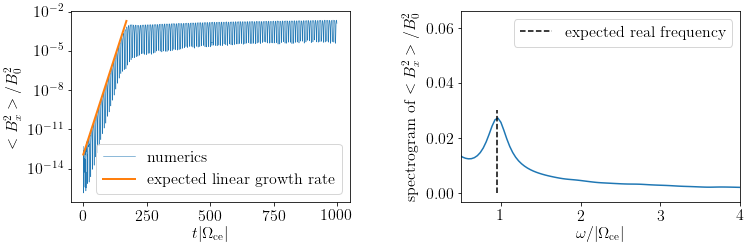

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from Utils.dispersionSolver import solveDispersion
from Utils.bsplines import Bspline



# ... import simulation data
data = np.loadtxt('Results/simulation_data_T=1000.txt')
# ...


# ... get simulation parameters
params = data[-1,:]
s = 6


wce = params[6]
wpe = params[7]
nuh = params[8]
wpar = params[10]
wperp = params[11]
k = params[12]
Lz = params[16]
Nz = int(params[17])
T = params[18]
dt = params[19]
p = int(params[20])

Nt = int(T/dt)
Nb = Nz
dz = Lz/Nz



uj = data[0:Nt+1,0:s*Nb]
uj = np.reshape(uj,(Nt+1,Nb,s))
# ...



# ... discretization parameters
dz = Lz/Nz
zj = np.linspace(0,Lz,Nz+1)

Nt = np.int(T/dt)
tn = np.linspace(0,T,Nt+1)
# ...




# ... create B-spline basis and quadrature grid
left = np.linspace(-p*dz,-dz,p)
right = np.linspace(Lz+dz,Lz+p*dz,p)
Tbsp = np.array(list(left)  + list(zj) + list(right))
bsp = Bspline(Tbsp,p)
N = len(Tbsp) - p - 1
xi,wi = np.polynomial.legendre.leggauss(p+1)
quad_points = np.zeros((p+1)*Nz)
weights = np.zeros((p+1)*Nz)

for i in range(0,Nz):
    a1 = zj[i]
    a2 = zj[i+1]
    xis = (a2-a1)/2*xi + (a1+a2)/2
    quad_points[(p+1)*i:(p+1)*i+(p+1)] = xis
    wis = (a2-a1)/2*wi
    weights[(p+1)*i:(p+1)*i+(p+1)] = wis
# ... 



# ... assemble mass and convection matrices
M = np.zeros((Nb,Nb))            
C = np.zeros((Nb,Nb))             

for ie in range(0,Nz):
    for il in range(0,p+1):
        for jl in range(0,p+1):
                
            i = il + ie  
            j = jl + ie
                
            value_m = 0.0
            value_c = 0.0
                
            for g in range(0,p+1):
                gl = ie*(p+1) + g
                    
                value_m += weights[gl]*bsp(quad_points[gl],i,0)*bsp(quad_points[gl],j,0)
                value_c += weights[gl]*bsp(quad_points[gl],i,0)*bsp(quad_points[gl],j,1)
                    
            M[i%Nb,j%Nb] += value_m
            C[i%Nb,j%Nb] += value_c
# ...






# ... solve the dispersion relation for a fixed k to get ocillation frequency an 
omega = solveDispersion(k,-1,wce,wpe,wpar,wperp,nuh,0.5+0.05j,1e-7)
omega_r = np.real(omega)
gamma = np.imag(omega)

mean_Bx2 = np.zeros(Nt+1)

for j in range(0,Nt+1):
    mean_Bx2[j] = 1/Lz*np.dot(uj[j,:,2],np.dot(M,uj[j,:,2]))
    
spec = np.fft.fft(mean_Bx2[0:3401])
spec = np.fft.fftshift(spec)
Nt = 3400
w = np.linspace(0,Nt,Nt+1) - Nt/2
w = 2*np.pi*w/(Nt*dt)

f1 = plt.figure()
f1.set_figheight(3.5)
f1.set_figwidth(12)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
plt.rc('text',usetex = True)
plt.rc('font',family = 'serif')
plt.rcParams.update({'font.size': 16})
plt.rc('xtick',labelsize = 16)
plt.rc('ytick',labelsize = 16)

plt.subplot(121)
plt.semilogy(tn,mean_Bx2,label = 'numerics',linewidth = 0.5)
t2 = np.linspace(0,170,100)
plt.semilogy(t2,1.2e-13*np.exp(t2*gamma*2),label = 'expected linear growth rate',linewidth = 2)
plt.xlabel(r'$t |\Omega_\mathrm{ce}|$')
plt.ylabel(r'$<B_x^2>/B_0^2$')
plt.legend()

plt.subplot(122)
plt.plot(w,np.abs(spec))
plt.xlim((0.5,4))
plt.xlabel(r'$\omega / |\Omega_\mathrm{ce}|$')
plt.ylabel(r'spectrogram of $<B_x^2>/B_0^2$')
plt.plot(np.ones(20)*2*omega_r,np.linspace(0,3e-2,20),'k--',label = 'expected real frequency')
plt.legend()

plt.savefig('/home/florian/Schreibtisch/Masterarbeit/05_Präsentationen/01_Summary/01_Figures/LongSimulation.pdf',bbox_inches = 'tight')

# Diagnostics of wavenumber scan

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from Utils.dispersionSolver import solveDispersion
from Utils.matrixAssembly import matrixAssembly
from Utils.createBasis import createBasis



# ... import simulation data
data1 = np.loadtxt('Results/01_WavenumberScan/simulation_data_T=400_k=1.5.txt')
data2 = np.loadtxt('Results/01_WavenumberScan/simulation_data_T=400_k=1.75.txt')
data3 = np.loadtxt('Results/01_WavenumberScan/simulation_data_T=400_k=2.0.txt')
data4 = np.loadtxt('Results/01_WavenumberScan/simulation_data_T=400_k=2.25.txt')
data5 = np.loadtxt('Results/01_WavenumberScan/simulation_data_T=400_k=2.5.txt')
print('almost done!')
data6 = np.loadtxt('Results/01_WavenumberScan/simulation_data_T=400_k=2.75.txt')
data7 = np.loadtxt('Results/01_WavenumberScan/simulation_data_T=400_k=3.0.txt')
# ...

almost done!


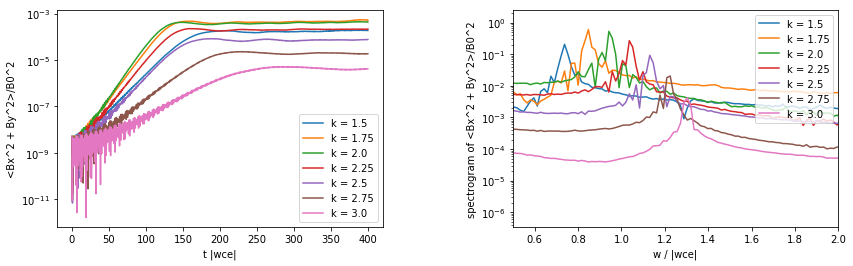

In [49]:
# ... get simulation parameters
pa = data1[0]

eps0  = pa[0]
mu0   = pa[1]
c     = pa[2]
qe    = pa[3]
me    = pa[4]
B0z   = pa[5]
wce   = pa[6]
wpe   = pa[7]
nuh   = pa[8]
nh    = pa[9]
wpar  = pa[10]
wperp = pa[11]
k     = pa[12]
ini   = np.int(pa[13])
amp   = pa[14]
eps   = pa[15]
Lz    = pa[16]
Nz    = np.int(pa[17])
T     = pa[18]
dt    = pa[19]
p     = np.int(pa[20])
Lv    = pa[21]
Nv    = np.int(pa[22])
Np    = np.int(pa[23])
# ...



# ... additional parameters 
Nb = Nz
s = 6
ordering = 0
# ...



# ... spatial discretization parameters
dz = Lz/Nz
zj = np.linspace(0,Lz,Nz+1)
# ...


# ... create B-spline basis and compute mass matrix
basis,N,quad_points,weights = createBasis(Lz,Nz,p)
M = matrixAssembly(basis,p,Nz,weights,quad_points)[0]
# ...




# ... get simulation data ej,bj,ycj and yhj
def getData(data,ordering):
    if ordering == 0:

        uj = data[1:,0:s*Nb]
        yhj = data[1:,s*Nb:8*Nb]

        ejx = uj[:,0::6]
        ejy = uj[:,1::6]
        bjx = uj[:,2::6]
        bjy = uj[:,3::6]
        ycjx = uj[:,4::6]
        ycjy = uj[:,5::6]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2]
        tn = data[1:,-1]
        Nt = len(tn) - 1

    elif ordering == 1:

        ej = data[1:Nt+2,0:2*Nb]
        bj = data[1:Nt+2,2*Nb:4*Nb]
        ycj = data[1:Nt+2,4*Nb:6*Nb]
        yhj = data[1:Nt+2,6*Nb:8*Nb]

        ejx = ej[:,0::2]
        ejy = ej[:,1::2]
        bjx = bj[:,0::2]
        bjy = bj[:,1::2]
        ycjx = ycj[:,0::2]
        ycjy = ycj[:,1::2]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2] 
        tn = data[1:Nt+2,-1]
        Nt = len(tn) - 1
        
    return ejx,ejy,bjx,bjy,ycjx,ycjy,yhjx,yhjy,tn,Nt



ks = np.array([1.5,1.75,2.0,2.25,2.5,2.75,3.0])


ejx = np.zeros((Nt+1,Nb,len(ks)))
ejy = np.zeros((Nt+1,Nb,len(ks)))
bjx = np.zeros((Nt+1,Nb,len(ks)))
bjy = np.zeros((Nt+1,Nb,len(ks)))
ycjx = np.zeros((Nt+1,Nb,len(ks)))
ycjy = np.zeros((Nt+1,Nb,len(ks)))
yhjx = np.zeros((Nt+1,Nb,len(ks)))
yhjy = np.zeros((Nt+1,Nb,len(ks)))
tn = np.zeros((Nt+1,len(ks)))

ejx[:,:,0],ejy[:,:,0],bjx[:,:,0],bjy[:,:,0],ycjx[:,:,0],ycjy[:,:,0],yhjx[:,:,0],yhjy[:,:,0],tn[:,0],Nt = getData(data1,ordering)
ejx[:,:,1],ejy[:,:,1],bjx[:,:,1],bjy[:,:,1],ycjx[:,:,1],ycjy[:,:,1],yhjx[:,:,1],yhjy[:,:,1],tn[:,1],Nt = getData(data2,ordering)
ejx[:,:,2],ejy[:,:,2],bjx[:,:,2],bjy[:,:,2],ycjx[:,:,2],ycjy[:,:,2],yhjx[:,:,2],yhjy[:,:,2],tn[:,2],Nt = getData(data3,ordering)
ejx[:,:,3],ejy[:,:,3],bjx[:,:,3],bjy[:,:,3],ycjx[:,:,3],ycjy[:,:,3],yhjx[:,:,3],yhjy[:,:,3],tn[:,3],Nt = getData(data4,ordering)
ejx[:,:,4],ejy[:,:,4],bjx[:,:,4],bjy[:,:,4],ycjx[:,:,4],ycjy[:,:,4],yhjx[:,:,4],yhjy[:,:,4],tn[:,4],Nt = getData(data5,ordering)
ejx[:,:,5],ejy[:,:,5],bjx[:,:,5],bjy[:,:,5],ycjx[:,:,5],ycjy[:,:,5],yhjx[:,:,5],yhjy[:,:,5],tn[:,5],Nt = getData(data6,ordering)
ejx[:,:,6],ejy[:,:,6],bjx[:,:,6],bjy[:,:,6],ycjx[:,:,6],ycjy[:,:,6],yhjx[:,:,6],yhjy[:,:,6],tn[:,6],Nt = getData(data7,ordering)

    
# ...











# ... solve the dispersion relation for a fixed k to get ocillation frequency and growth rate 
omega = np.zeros(len(ks),dtype = complex)
omega_r = np.zeros(len(ks))
gamma = np.zeros(len(ks))

for i in range(0,len(ks)):
    omega[i] = solveDispersion(ks[i],-1,wce,wpe,wpar,wperp,nuh,0.5 + 0.04j,1e-7)
    omega_r[i] = np.real(omega[i])
    gamma[i] = np.imag(omega[i])
# ...





# ... compute averaged quadratic magnetic field
mean_Bx2 = np.zeros((Nt+1,len(ks)))
mean_B2 = np.zeros((Nt+1,len(ks)))

for i in range(0,len(ks)):
    for j in range(0,Nt+1):
        mean_Bx2[j,i] = 1/Lz*np.dot(bjx[j,:,i],np.dot(M,bjx[j,:,i]))
        mean_B2[j,i] = 1/Lz*(np.dot(bjx[j,:,i],np.dot(M,bjx[j,:,i])) + np.dot(bjy[j,:,i],np.dot(M,bjy[j,:,i])))
# ...

                       
                      
# ... compute ffts for frequency analysis  
spec = np.zeros((Nt+1,len(ks)),dtype = complex)
for i in range(0,len(ks)):
    spec[:,i] = np.fft.fft(mean_Bx2[:,i])
    spec[:,i] = np.fft.fftshift(spec[:,i])
    
w = np.linspace(0,Nt,Nt+1) - Nt/2
w = 2*np.pi*w/T
# ...

 
                       
# ... plot results
f1 = plt.figure()
f1.set_figheight(4)
f1.set_figwidth(14)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)

tend = np.array([170,140,140,140,150,170,250])

plt.subplot(121)
for i in range(0,len(ks)):
    plt.semilogy(tn[:,i],mean_B2[:,i],label = 'k = ' + str(ks[i]))
    t2 = np.linspace(0,tend[i],100)
    #plt.semilogy(t2,1.00e-9*np.exp(t2*gamma[i]*2),'k--')
    
plt.xlabel('t |wce|')
plt.ylabel('<Bx^2 + By^2>/B0^2')
plt.legend()



plt.subplot(122)
for i in range(0,len(ks)):
    plt.semilogy(w,np.abs(spec[:,i]),label = 'k = ' + str(ks[i]))
    #plt.plot(np.ones(20)*2*omega_r,np.linspace(0,6e-5,20),label = 'expected real frequency')

plt.xlim((0.5,2))
plt.xlabel('w / |wce|')
plt.ylabel('spectrogram of <Bx^2 + By^2>/B0^2')
plt.legend(loc = 1)

# ...